## Import Packages and Data

In [1]:
# AYU CODE
import pickle

from scipy import fft
from qtn.bimax import BiMax
from qtn.util import (boltzmann, emass, echarge, permittivity, cspeed, fperp, fp)
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from pyspedas import wind
from pytplot import tplot, get_data
import pandas as pd
import time
import netCDF4 as nc
from functions import Timer
%matplotlib inline

In [2]:
T = Timer.Timer()
T.start()

In [3]:
ant_len = 50      # m (monopole) 
ant_rad = 1.9e-4  # m
base_cap = 20e-12 # Farad
fbins = np.array([4000*1.0445**i for i in range(96)])

In [4]:
def find_closest_time(time, lst):
    """
    A function used to find the index of the closest time in a list 
    to the specific time held in the variable time
    """
    return min(range(len(lst)), key=lambda i: abs(time-lst[i]))

In [5]:
#data = wind.waves(trange=['1995-6-25', '1995-6-26'],get_support_data=True)
ds =  nc.Dataset("data/wi_wav_tnr_19950625.nc")
print(ds)
print(np.size(ds["tnr_ch1_time"][:]))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): n_times(19419), n_bins(96)
    variables(dimensions): float64 tnr_ch1_time(n_times), float64 tnr_ch1_freq(n_bins), float64 tnr_ch1_spec(n_bins, n_times)
    groups: 
19419


## Plot 1: June 25, 1995 06:33:06.432

### Theoretical

## Imported Parameters
* vsw: Solar Wind Speed                  - Solar Wind Experiment(SWE)
* tc: core electron temperature ~ electron temperature - statistical paper 
* fpe: core electron plasma frequency    - Use WIND/WAVES NN
* ne: electron density                   - Use WIND/WAVES NN
* t: halo/core electron temperature ratio - 
* n: halo/core electron density ratio     - 
* tep: electron to proton temperature ratio - statistical paper 

## Calculated Parameters
* nc: core electron density       
* ldc: core debye length                 
* lrel: relative length of antenna

In [6]:
vsw=3.966e5                   # Solar Wind Speed
tc = 9.91 * echarge/boltzmann # Core electron temperature
t = 6.57                      # ??? Only used to calculate electron noise and shot noise
n = 0.026                     # ??? Some sort of ratio between core electron and normal electron density
tep = 9.91/9.62               # Electron Temperature/Proton Temperature Ratio
fpe = 31.47e3                 # Electron Plasma Frequency

In [7]:
ne = 12.28e6                  # Electron Density
nc = ne/(1+n)                 # ??? Core Electron Density
ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2) # Debye Length
lrel = ant_len/ldc            # Relative length antenna to debye length
print(lrel)

7.391617810601882


In [8]:
wrelplot = fbins/fpe

In [9]:
print(f"BiMax({ant_len}, {ant_rad}, {base_cap})")
print(f"p.gamma_shot({wrelplot[0]}, {lrel}, {n}, {t}, {tc})")

BiMax(50, 0.00019, 2e-11)
p.gamma_shot(0.1271051795360661, 7.391617810601882, 0.026, 6.57, 115000.78664972584)


In [10]:
p = BiMax(ant_len, ant_rad, base_cap,False)

In [11]:
T.lap("Gamma_shot")
g_s = np.array([p.gamma_shot(wrel, lrel, n, t, tc) for wrel in wrelplot])


In [12]:
def helper(wrel):
    """
    add precision control to bimax function.
    
    """
    if wrel > 1 and wrel < 1.2:
        mp.mp.dps = 40
    else:
        mp.mp.dps = 20
    #mp.mp.dps = 3
    return p.bimax(wrel, lrel, n, t, tc)

In [13]:
T.lap("Enoise")
enoise = np.array([helper(wrel) for wrel in wrelplot])

In [14]:
#Modified by AYU 
# - Was running into an parameter error 
# - need to fix to match up with reference graph
#pnoise = np.array([p.proton(wrel*np.sqrt(1+n), ne, n, t, tep, tc, vsw) for wrel in wrelplot])
T.lap("Pnoise")
pnoise = np.array([p.proton2(wrel*np.sqrt(1+n), lrel, tep, tc, vsw) for wrel in wrelplot])

In [15]:
T.lap("Addition")
gamma = g_s[:, 0]
shot = g_s[:, 1]
vr2 = enoise + pnoise + shot

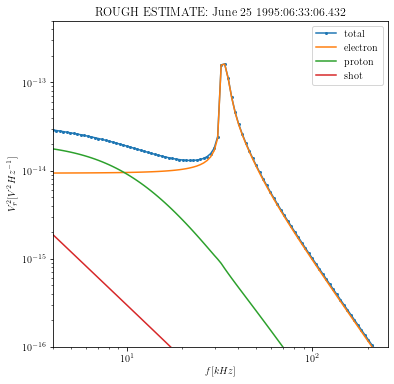

In [16]:
T.lap("Plot")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6], facecolor='w')
plt.plot(fbins/1000, vr2/gamma, 'o-', markersize=2, label='total')
plt.plot(fbins/1000, enoise/gamma, label='electron')
plt.plot(fbins/1000, pnoise/gamma, label='proton')
plt.plot(fbins/1000, shot/gamma, label='shot')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('ROUGH ESTIMATE: June 25 1995:06:33:06.432')
plt.legend(loc='best')
plt.show()

In [17]:
T.stop()
print(T.summary())

Total Time: 160.3173971176
Name: Elapsed Time
Gamma_shot: 106.8418605328
Enoise: 42.0459327698
Pnoise: 0.6923296452
Addition: 0.0091142654
Plot: 0.3386869431



In [18]:
print(vr2)

[mpf('3.8203087224414107682645e-14') mpf('3.7663664808550005983629e-14')
 mpf('3.7121095572148527229478e-14') mpf('3.6573809350308495739777e-14')
 mpf('3.6018445193847246853161e-14') mpf('3.5454354550694630515591e-14')
 mpf('3.4881108693359805313835e-14') mpf('3.4295865422628757967023e-14')
 mpf('3.3699799575462098149282e-14') mpf('3.3091815895407424192943e-14')
 mpf('3.2470674285897161063549e-14') mpf('3.1838191583474359642287e-14')
 mpf('3.1194638209354423831293e-14') mpf('3.0539497526845043517676e-14')
 mpf('2.9875328869808386663991e-14') mpf('2.920360256940664725867e-14')
 mpf('2.8524882290308030615218e-14') mpf('2.7841948715372230660774e-14')
 mpf('2.7157534665724886240652e-14') mpf('2.6472962023664212881799e-14')
 mpf('2.5791476016794287101869e-14') mpf('2.5116170246009022965961e-14')
 mpf('2.4449374132797138706808e-14') mpf('2.3794029144569436082631e-14')
 mpf('2.3153597834985447096155e-14') mpf('2.2530515896114616765829e-14')
 mpf('2.1927498650535632638443e-14') mpf('2.13478991

In [20]:
raise error
fig.savefig('plots/wind19950625_theoretical.png', dpi=300)

NameError: name 'error' is not defined

### Experimental

## Plot 2: June 25, 1995 18:52:34.344 GMT

In [ ]:
assert False

### Theoretical

In [ ]:
vsw=7.61e5
tc = 11.53 * echarge/boltzmann
t = 5.57
n = 0.059
tep = 11.53/47.49
fpe = 22.24e3
te = tc * (1 + n)/(1 + n/t)
print(te)
te = te

In [ ]:
ne = 6.13e6
nc = ne/(1+n)
ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2)
lc = ant_len/ldc
print(lc)
lde = np.sqrt(permittivity * boltzmann * te/ ne / echarge**2)
le = ant_len/lde
print(le)

In [ ]:
p = BiMax(ant_len, ant_rad, base_cap)

In [ ]:
wrelplot = fbins/fpe

In [ ]:
#wrelplot = wrelplot[0:2]

In [ ]:
g_s = np.array([p.gamma_shot(wrel, lrel, n, t, tc) for wrel in wrelplot])

In [ ]:
wrelplot[0]

In [ ]:
wrel = wrelplot[0]
print(p.gamma_shot(wrel, lrel, n, t, tc))
print(p.proton2(wrel, lc, tep, tc, vsw))
print(p.proton2(wrel, le, tep, te, vsw))

In [ ]:
p.proton2(0.1, le, tep, te, vsw)

In [ ]:
def helper(wrel):
    """
    add precision control to bimax function.
    
    """
    if wrel > 1 and wrel < 1.2:
        mp.mp.dps = 40
    else:
        mp.mp.dps = 20
    return p.bimax(wrel, lrel, n, t, tc)

In [ ]:
enoise = np.array([helper(wrel) for wrel in wrelplot])

In [ ]:
pnoise = np.array([p.proton2(wrel*np.sqrt(1+n), lrel, tep, tc, vsw) for wrel in wrelplot])

In [ ]:
fig = plt.figure(figsize=[6, 6])
plt.plot(fbins/1000, pnoise, label='proton')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 19 1995:18:52:35.344')
plt.legend(loc='best')
plt.show()

In [ ]:
gamma = g_s[:, 0]
shot = g_s[:, 1]
vr2 = enoise + pnoise + shot

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6])
plt.plot(fbins/1000, vr2/gamma, 'o-', markersize=2, label='total')
plt.plot(fbins/1000, enoise/gamma, label='electron')
plt.plot(fbins/1000, pnoise/gamma, label='proton')
plt.plot(fbins/1000, shot/gamma, label='shot')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 19 1995:18:52:35.344')
plt.legend(loc='best')
plt.show()

In [ ]:
fig.savefig('plots/wind19950619_theoretical.png', dpi=300)